In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
proj_path = "/content/drive/My Drive/AIML/data/capstone/"

import os, sys # 2nd way
os.chdir(proj_path)

# Add the path to the sys.path for this session
sys.path.append(proj_path)


In [ ]:
pip install pydicom

     |████████████████████████████████| 1.9MB 5.2MB/s 


In [ ]:
# Imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt, sklearn, re, random

import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import pydicom as dcm
%matplotlib inline

import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm
import tensorflow, cv2
%matplotlib inline

# Extract content from zipfile
from zipfile import ZipFile

# Model
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from sklearn.svm import SVC

# Encode, standardize and PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Set random_state
random_state = 2020

# Suppress warnings, if any
import warnings; warnings.filterwarnings('ignore')

# Print versions
print(f'Pandas version: {pd.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'Scikit-learn version: {sklearn.__version__}')
print(f'Tensorflow version: {tensorflow.__version__}')
print(f'CV version: {cv2.__version__}')

Pandas version: 1.1.5
Numpy version: 1.19.5
Scikit-learn version: 0.22.2.post1
Tensorflow version: 2.4.1
CV version: 4.1.2


In [ ]:
class_info_df = pd.read_csv('stage_2_detailed_class_info.csv')
train_labels_df = pd.read_csv('stage_2_train_labels.csv') 

In [ ]:
print(f"Detailed class info -  rows: {class_info_df.shape[0]}, columns: {class_info_df.shape[1]}")
print(f"Train labels -  rows: {train_labels_df.shape[0]}, columns: {train_labels_df.shape[1]}")

Detailed class info -  rows: 30227, columns: 2
Train labels -  rows: 30227, columns: 6


In [ ]:
merge_train_df = train_labels_df.merge(class_info_df, left_on='patientId', right_on='patientId', how='inner')

merge_train_df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [ ]:
import os
import csv
import random
import pydicom
import numpy as np
import pandas as pd
from skimage import measure
from skimage.transform import resize
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
%matplotlib inline

In [ ]:
df=pd.read_csv('stage_2_train_labels.csv')

In [ ]:
df['path']='stage_2_train_images/'+df['patientId'].astype(str)+'.dcm'

In [ ]:
negative=df[df['Target']==0]
print(len(negative))

20672


In [ ]:
positive=df[df['Target']==1]
unique_positive=positive[['path','patientId']]
path=unique_positive['path'].unique()
patientId=unique_positive['patientId'].unique()

unique_positive=pd.DataFrame({'path':path,'patientId':patientId})
len(unique_positive)

6012

In [ ]:
for _,row in tqdm(unique_positive.iterrows()):
    img=dcm.read_file(row['path']).pixel_array
    img=resize(img,(256,256))
    plt.imsave(proj_path+'data/positive/'+row['patientId']+'.jpg',img,cmap='gray')

In [ ]:
for _,row in tqdm(negative.iterrows()):
    img=dcm.read_file(row['path']).pixel_array
    img=resize(img,(256,256))
    plt.imsave(proj_path+'data/negative/'+row['patientId']+'.jpg',img,cmap='gray')

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19,preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen=ImageDataGenerator(samplewise_center=True,samplewise_std_normalization=True,horizontal_flip=True,
                          width_shift_range=0.05,rescale=1/255,fill_mode='nearest',height_shift_range=0.05,
                           preprocessing_function=preprocess_input,validation_split=0.3,
                          )

In [ ]:
train=datagen.flow_from_directory('data',color_mode='rgb',batch_size=32,
                                  class_mode='binary',subset='training')
test=datagen.flow_from_directory('data',color_mode='rgb',batch_size=32,
                                 class_mode='binary',subset='validation')

Found 4209 images belonging to 2 classes.
Found 8004 images belonging to 2 classes.


In [ ]:
pre_trained_model = VGG19(input_shape = (256,256,3), 
                                include_top = False, 
                                weights = 'imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = False

# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

80142336/80134624 [==============================] - 0s 0us/step
last layer output shape:  (None, 8, 8, 512)


In [ ]:
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,LeakyReLU,ReLU,GaussianDropout

In [ ]:
model = Flatten()(last_output)
model = Dense(1024)(model)
model=LeakyReLU(0.1)(model)
model=Dropout(0.25)(model)
model=BatchNormalization()(model)
model = Dense(1024)(model)
model=LeakyReLU(0.1)(model)
model=Dropout(0.25)(model)
model=BatchNormalization()(model)
model = Dense(1, activation='sigmoid')(model)

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
fmodel = Model( pre_trained_model.input, model) 

fmodel.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
fmodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [ ]:
early=EarlyStopping(monitor='accuracy',patience=3,mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.5, 
                              patience=2, verbose=1,cooldown=0, mode='auto',min_delta=0.0001, min_lr=1e-5)

In [ ]:
class_weight={0:1,1:3.3}

fmodel.fit(train,epochs=5,callbacks=[reduce_lr],
            steps_per_epoch=100,validation_data=test,class_weight=class_weight)

Epoch 1/5
100/100 [==============================] - 9335s 94s/step - loss: 2.4426 - accuracy: 0.6547 - val_loss: 1.9131 - val_accuracy: 0.2253
Epoch 2/5
100/100 [==============================] - 9205s 93s/step - loss: 0.3641 - accuracy: 0.9824 - val_loss: 3.8399 - val_accuracy: 0.2253
Epoch 3/5
100/100 [==============================] - 9167s 92s/step - loss: 0.0878 - accuracy: 0.9989 - val_loss: 4.0414 - val_accuracy: 0.2253
Epoch 4/5
100/100 [==============================] - 9208s 93s/step - loss: 0.0316 - accuracy: 1.0000 - val_loss: 4.6197 - val_accuracy: 0.2253
Epoch 5/5
100/100 [==============================] - ETA: 0s - loss: 0.0140 - accuracy: 1.0000 

In [ ]:
#fmodel.save(proj_path +'/model_vgg19.h5')

In [ ]:
# # Plot accuracy
# plt.figure(figsize=(30,20))
# val_acc=np.asarray(fmodel.history.history['val_accuracy'])*100
# acc=np.asarray(fmodel.history.history['accuracy'])*100
# acc=pd.DataFrame({'val_acc':val_acc,'acc':acc})
# acc.plot(figsize=(20,10),yticks=range(50,100,5))

In [ ]:
# # Plot loss
# loss=fmodel.history.history['loss']
# val_loss=fmodel.history.history['val_loss']
# loss=pd.DataFrame({'val_loss':val_loss,'loss':loss})
# loss.plot(figsize=(20,10))

In [ ]:
# y=[]

# test.reset()

# for i in tqdm(range(84)):
#     _,tar=test.__getitem__(i)
#     for j in tar:
#         y.append(j)

In [ ]:
# test.reset()
# y_pred=fmodel.predict(test)

In [ ]:
# pred=[]
# for i in y_pred:
#     if i[0]>=0.5:
#         pred.append(1)
#     else:
#         pred.append(0)

In [ ]:
# from sklearn.metrics import roc_curve,auc,precision_recall_curve,classification_report

In [ ]:
# # Classification report
# print(classification_report(y,pred[:len(y)]))

In [ ]:
# plt.figure(figsize=(30,20))
# fpr,tpr,_=roc_curve(y,y_pred[:len(y)])
# area_under_curve=auc(fpr,tpr)
# print('The area under the curve is:',area_under_curve)
# # Plot area under curve
# plt.plot(fpr,tpr,'b.-')
# plt.xlabel('false positive rate')
# plt.ylabel('true positive rate')
# plt.plot(fpr,fpr,linestyle='--',color='black')

=================layer with ReLU layer======================

In [ ]:
model = Flatten()(last_output)
model = Dense(1024)(model)
model=ReLU(0.1)(model)
model=Dropout(0.25)(model)
model=BatchNormalization()(model)
model = Dense(1024)(model)
model=ReLU(0.1)(model)
model=Dropout(0.25)(model)
model=BatchNormalization()(model)
model = Dense(1, activation='sigmoid')(model)

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
fmodel = Model( pre_trained_model.input, model) 

fmodel.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
fmodel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [ ]:
early=EarlyStopping(monitor='accuracy',patience=3,mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.5, 
                              patience=2, verbose=1,cooldown=0, mode='auto',min_delta=0.0001, min_lr=1e-5)

In [ ]:
class_weight={0:1,1:3.3}
# Train model
fmodel.fit(train,epochs=5,callbacks=[reduce_lr],
           steps_per_epoch=100,validation_data=test,class_weight=class_weight)

Epoch 1/5
100/100 [==============================] - 9361s 94s/step - loss: 0.8936 - accuracy: 0.8995 - val_loss: 2.7755 - val_accuracy: 0.2253
Epoch 2/5
100/100 [==============================] - 9306s 94s/step - loss: 0.0936 - accuracy: 0.9997 - val_loss: 3.9367 - val_accuracy: 0.2253
Epoch 3/5
100/100 [==============================] - 9271s 93s/step - loss: 0.0277 - accuracy: 1.0000 - val_loss: 4.4043 - val_accuracy: 0.2253
Epoch 4/5
100/100 [==============================] - 9275s 93s/step - loss: 0.0131 - accuracy: 1.0000 - val_loss: 4.9709 - val_accuracy: 0.2253
Epoch 5/5
  4/100 [>.............................] - ETA: 42:36 - loss: 0.0104 - accuracy: 1.0000

KeyboardInterrupt: ignored

<Figure size 2160x1440 with 0 Axes>

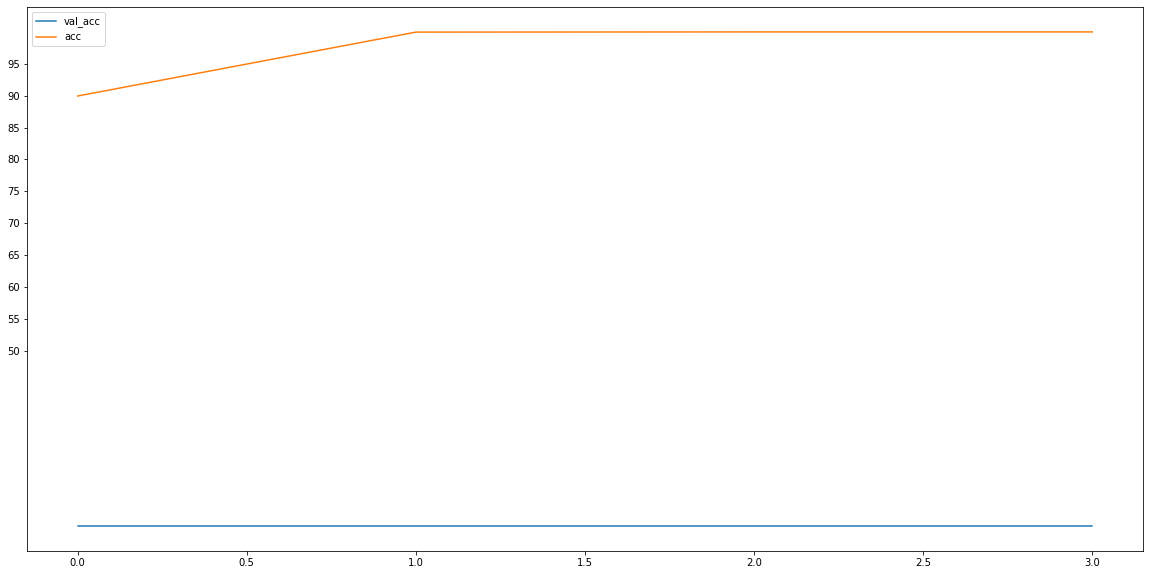

In [ ]:
plt.figure(figsize=(30,20))
val_acc=np.asarray(fmodel.history.history['val_accuracy'])*100
acc=np.asarray(fmodel.history.history['accuracy'])*100
acc=pd.DataFrame({'val_acc':val_acc,'acc':acc})
acc.plot(figsize=(20,10),yticks=range(50,100,5))

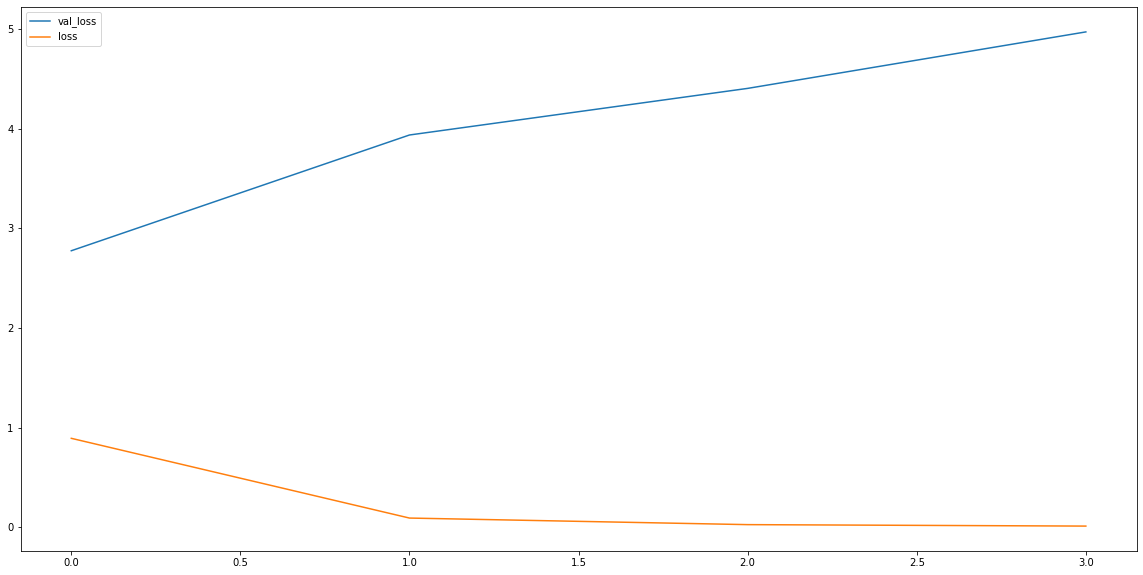

In [ ]:
loss=fmodel.history.history['loss']
val_loss=fmodel.history.history['val_loss']
loss=pd.DataFrame({'val_loss':val_loss,'loss':loss})
loss.plot(figsize=(20,10))

In [ ]:
y=[]

test.reset()

for i in tqdm(range(84)):
    _,tar=test.__getitem__(i)
    for j in tar:
        y.append(j)

In [ ]:
test.reset()
y_pred=fmodel.predict(test)

In [ ]:
pred=[]
for i in y_pred:
    if i[0]>=0.5:
        pred.append(1)
    else:
        pred.append(0)

In [ ]:
from sklearn.metrics import roc_curve,auc,precision_recall_curve,classification_report

In [ ]:
# Classification report
print(classification_report(y,pred[:len(y)]))

              precision    recall  f1-score   support

         0.0       0.78      0.98      0.87      2085
         1.0       0.47      0.05      0.09       603

    accuracy                           0.77      2688
   macro avg       0.63      0.52      0.48      2688
weighted avg       0.71      0.77      0.70      2688



The area under the curve is: 0.6108072745783473


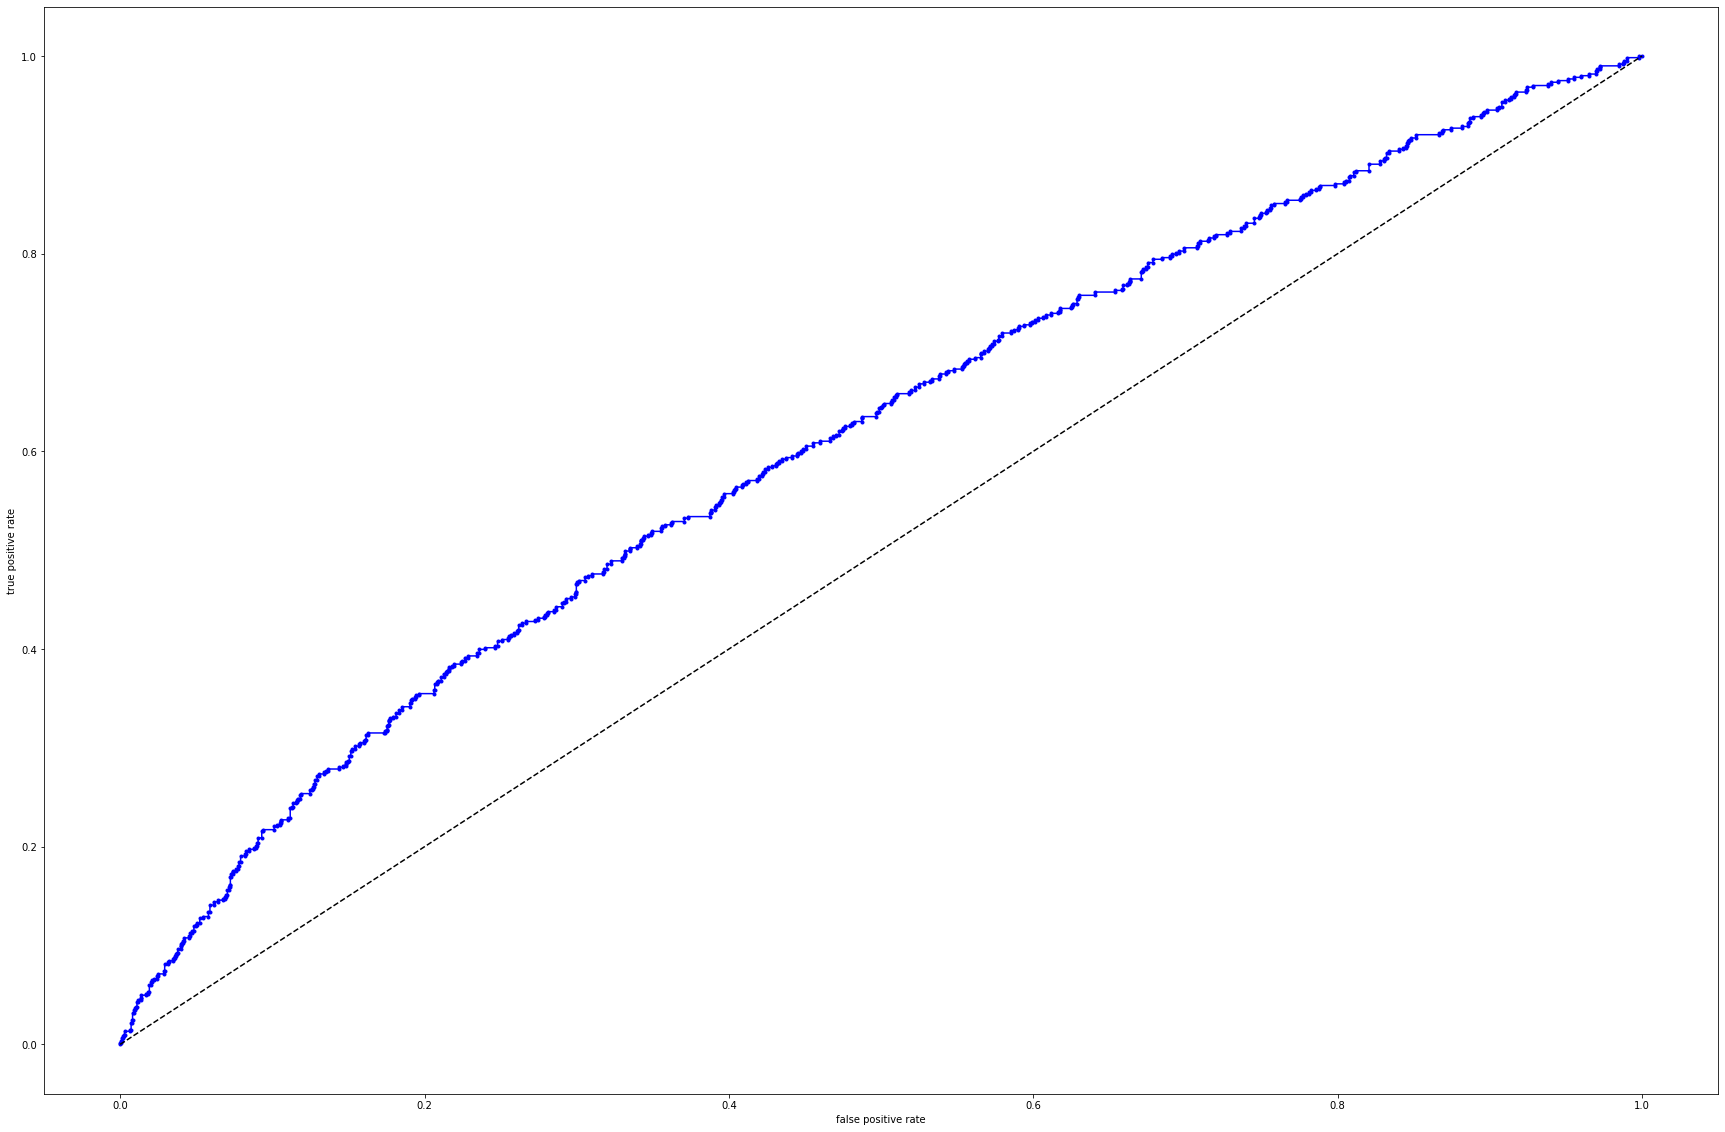

In [ ]:
plt.figure(figsize=(30,20))
fpr,tpr,_=roc_curve(y,y_pred[:len(y)])
area_under_curve=auc(fpr,tpr)
print('The area under the curve is:',area_under_curve)
# Plot area under curve
plt.plot(fpr,tpr,'b.-')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.plot(fpr,fpr,linestyle='--',color='black')